# LAPTOP PRICE PREDICTOR

**IMPORTING THE LIBRARIES**

In [32]:
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

* *Reading Files*

In [33]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
a = '/kaggle/input/laptop-price-analysis/laptops_train.csv'
df= pd.read_csv(a)

/kaggle/input/laptop-price-analysis/laptops_train.csv


Viewing the top 5 rows of the dataset

In [34]:
df.head()

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,NaN,1.37kg,11912523.48
1,Apple,Macbook Air,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,NaN,1.34kg,7993374.48
2,HP,250 G6,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,NaN,1.86kg,5112900.00
3,Apple,MacBook Pro,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,NaN,1.83kg,22563005.40
4,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,NaN,1.37kg,16037611.20


**Splitting the data to get Price of Laptop**

In [35]:
y=df.Price
X = df.drop(['Price'], axis=1)
X

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight
0,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,NaN,1.37kg
1,Apple,Macbook Air,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,NaN,1.34kg
2,HP,250 G6,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,NaN,1.86kg
3,Apple,MacBook Pro,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,NaN,1.83kg
4,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,NaN,1.37kg
...,...,...,...,...,...,...,...,...,...,...,...,...
972,Dell,Alienware 17,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,32GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows,10,4.42kg
973,Toshiba,Tecra A40-C-1DF,Notebook,"14.0""",Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows,10,1.95kg
974,Asus,Rog Strix,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1060,Windows,10,2.73kg
975,HP,Probook 450,Notebook,"15.6""",IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.70GHz,8GB,128GB SSD + 1TB HDD,Nvidia GeForce 930MX,Windows,10,2.04kg


In [36]:
y

0      11912523.48
1       7993374.48
2       5112900.00
3      22563005.40
4      16037611.20
          ...     
972    24897600.00
973    10492560.00
974    18227710.80
975     8705268.00
976     8909784.00
Name: Price, Length: 977, dtype: float64

# **DATA OBSERVATION**

**1. BOX PLOT (RAM vs Price)**

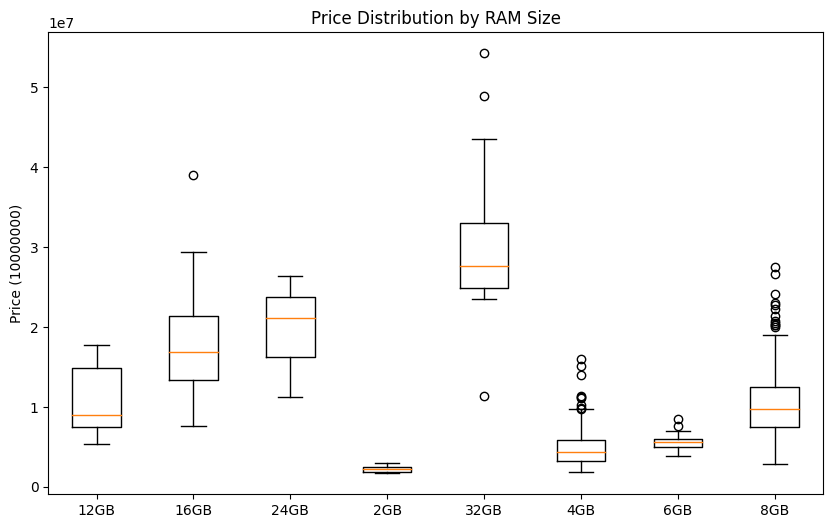

In [37]:
unique_ram_sizes = sorted(df['RAM'].unique())
plt.figure(figsize=(10, 6))
plt.boxplot([df[df['RAM'] == RAM]['Price'] for RAM in unique_ram_sizes],
            labels=unique_ram_sizes)
plt.ylabel('Price (10000000)')
plt.title('Price Distribution by RAM Size')
plt.xticks(rotation=0)
plt.show()


From above box plot we can observe that the price of a laptop is directly proportional to RAM Size. It is therefore a good feature for model.

**2. Violin Plot (Operating System vs Price)**

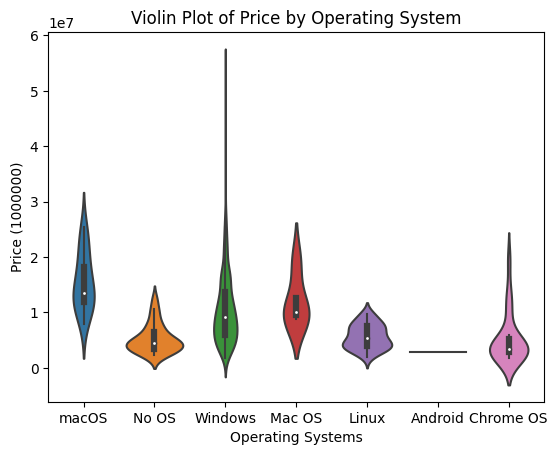

In [38]:
sns.violinplot(x='Operating System', y='Price', data=df)
plt.xlabel('Operating Systems')
plt.ylabel('Price (1000000)')
plt.title('Violin Plot of Price by Operating System')
plt.show()

From above violin plot, we can observe the various operating systems are lying in the same price range in general. Thats why for predicting a model with lower price the Operating System might be a bad feature.

*We cannot process String values directly. Those values which have some integer values with some Strings are removed below:*

In [39]:
X['Screen Size'] = X['Screen Size'].str.rstrip('''"''').astype(float)
X['RAM'] = X['RAM'].str.rstrip("GB").astype(float)
X['Weight'] = X['Weight'].str.rstrip("kg").astype(float)

Column Storage has various types of Storage devices like SSD, HDD, Flash Storage and Hybrid. Given below, the data are seprated below and their String values are cut off converting all the values in terms of GB(Giga Bytes).

In [40]:
storage_types = ['SSD', 'HDD', 'Flash Storage', 'Hybrid']
for storage_type in storage_types:
    # Extract size information and convert TB to GB
    size_column = X['Storage'].str.extract(r'(\d+)GB? ' + re.escape(storage_type))
    size_column = size_column.astype(float)

    # Check if the storage type is HDD, and if so, convert TB to GB
    if storage_type == 'HDD':
        tb_size_column = X['Storage'].str.extract(r'(\d+)TB ' + re.escape(storage_type))
        tb_size_column = tb_size_column.astype(float) * 1024  # Convert TB to GB
        size_column = size_column.combine_first(tb_size_column)

    X[storage_type + '_Size'] = size_column.fillna(0)  # Fill NaN with 0 for missing sizes

# Drop the original 'Storage' column if needed
X.drop(columns=['Storage'], inplace=True)
X

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,GPU,Operating System,Operating System Version,Weight,SSD_Size,HDD_Size,Flash Storage_Size,Hybrid_Size
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8.0,Intel Iris Plus Graphics 640,macOS,NaN,1.37,128.0,0.0,0.0,0.0
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8.0,Intel HD Graphics 6000,macOS,NaN,1.34,0.0,0.0,128.0,0.0
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8.0,Intel HD Graphics 620,No OS,NaN,1.86,256.0,0.0,0.0,0.0
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16.0,AMD Radeon Pro 455,macOS,NaN,1.83,512.0,0.0,0.0,0.0
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8.0,Intel Iris Plus Graphics 650,macOS,NaN,1.37,256.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,Dell,Alienware 17,Gaming,17.3,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,32.0,Nvidia GeForce GTX 1070,Windows,10,4.42,256.0,1024.0,0.0,0.0
973,Toshiba,Tecra A40-C-1DF,Notebook,14.0,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8.0,Intel HD Graphics 520,Windows,10,1.95,256.0,0.0,0.0,0.0
974,Asus,Rog Strix,Gaming,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16.0,Nvidia GeForce GTX 1060,Windows,10,2.73,256.0,1024.0,0.0,0.0
975,HP,Probook 450,Notebook,15.6,IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.70GHz,8.0,Nvidia GeForce 930MX,Windows,10,2.04,128.0,1024.0,0.0,0.0


***Checking for columns with null values***

In [41]:
null_columns = X.columns[X.isnull().any()]
null_count = X.isnull().sum()
null_columns
null_count

Manufacturer                  0
Model Name                    0
Category                      0
Screen Size                   0
Screen                        0
CPU                           0
RAM                           0
GPU                           0
Operating System              0
Operating System Version    136
Weight                        0
SSD_Size                      0
HDD_Size                      0
Flash Storage_Size            0
Hybrid_Size                   0
dtype: int64

Its better to remove Operating System and its version as it is not a better feature as well as there are various null values 

In [42]:
columns_to_drop = ['Operating System Version','Operating System']
X = X.drop(columns=columns_to_drop)
X

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,GPU,Weight,SSD_Size,HDD_Size,Flash Storage_Size,Hybrid_Size
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8.0,Intel Iris Plus Graphics 640,1.37,128.0,0.0,0.0,0.0
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8.0,Intel HD Graphics 6000,1.34,0.0,0.0,128.0,0.0
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8.0,Intel HD Graphics 620,1.86,256.0,0.0,0.0,0.0
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16.0,AMD Radeon Pro 455,1.83,512.0,0.0,0.0,0.0
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8.0,Intel Iris Plus Graphics 650,1.37,256.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,Dell,Alienware 17,Gaming,17.3,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,32.0,Nvidia GeForce GTX 1070,4.42,256.0,1024.0,0.0,0.0
973,Toshiba,Tecra A40-C-1DF,Notebook,14.0,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8.0,Intel HD Graphics 520,1.95,256.0,0.0,0.0,0.0
974,Asus,Rog Strix,Gaming,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16.0,Nvidia GeForce GTX 1060,2.73,256.0,1024.0,0.0,0.0
975,HP,Probook 450,Notebook,15.6,IPS Panel Full HD 1920x1080,Intel Core i5 7200U 2.70GHz,8.0,Nvidia GeForce 930MX,2.04,128.0,1024.0,0.0,0.0


**Now splitting the data into train and test data for training model**

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=1)

**Checking for categorical datatypes in the dataset**

In [44]:
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]
object_cols

['Manufacturer', 'Model Name', 'Category', 'Screen', 'CPU', 'GPU']

**Using OrdinalEncoder to encode the categorical datatypes in the dataset****

In [45]:
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
X_test[object_cols] = ordinal_encoder.transform(X_test[object_cols])


In [46]:
X_train

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,GPU,Weight,SSD_Size,HDD_Size,Flash Storage_Size,Hybrid_Size
228,2.0,181.0,3.0,17.3,8.0,56.0,8.0,70.0,2.69,256.0,500.0,0.0,0.0
758,4.0,39.0,1.0,15.6,12.0,77.0,16.0,64.0,4.42,256.0,1024.0,0.0,0.0
177,11.0,123.0,1.0,18.4,8.0,71.0,32.0,47.0,4.40,512.0,1024.0,0.0,0.0
677,7.0,66.0,0.0,11.6,33.0,28.0,8.0,31.0,1.40,0.0,0.0,64.0,0.0
60,4.0,174.0,3.0,17.3,8.0,81.0,16.0,5.0,2.80,256.0,2048.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,4.0,175.0,1.0,15.6,26.0,68.0,16.0,73.0,2.72,128.0,1024.0,0.0,0.0
72,4.0,170.0,3.0,15.6,8.0,81.0,8.0,5.0,2.20,256.0,0.0,0.0,0.0
908,10.0,153.0,3.0,15.6,15.0,52.0,8.0,73.0,2.60,128.0,1024.0,0.0,0.0
235,4.0,169.0,3.0,15.6,8.0,73.0,16.0,21.0,2.36,256.0,0.0,0.0,0.0


In [47]:
X_test

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,GPU,Weight,SSD_Size,HDD_Size,Flash Storage_Size,Hybrid_Size
932,7.0,34.0,3.0,15.6,0.0,27.0,4.0,29.0,1.86,0.0,1024.0,0.0,0.0
724,11.0,111.0,1.0,17.3,8.0,77.0,8.0,60.0,2.70,128.0,1024.0,0.0,0.0
525,10.0,307.0,3.0,14.0,8.0,50.0,8.0,35.0,2.02,256.0,0.0,0.0,0.0
6,1.0,206.0,4.0,15.4,25.0,-1.0,16.0,-1.0,2.04,0.0,0.0,256.0,0.0
248,7.0,245.0,3.0,13.3,15.0,63.0,4.0,46.0,1.49,0.0,500.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,4.0,168.0,0.0,13.3,13.0,81.0,8.0,46.0,1.62,0.0,1024.0,0.0,0.0
895,16.0,-1.0,3.0,13.3,8.0,56.0,8.0,40.0,1.05,256.0,0.0,0.0,0.0
567,5.0,-1.0,3.0,15.6,0.0,56.0,8.0,40.0,2.20,0.0,1024.0,0.0,0.0
414,2.0,405.0,0.0,13.3,13.0,56.0,8.0,40.0,1.27,256.0,0.0,0.0,0.0


***Training the model with XGB Regressor ***

In [48]:
my_model = XGBRegressor(
    n_estimators=2000, 
    learning_rate=0.005, 
    early_stopping_rounds=10
)

my_model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_test, y_test)], 
    verbose=False
)
# Get predictions
predictions = my_model.predict(X_test)


# Calculate MAE
mae = mean_absolute_error(predictions,y_test)
print("Mean Absolute Error:" , mae)

Mean Absolute Error: 1851231.0615816326


In [49]:
predictions

array([ 2720834. , 10668789. ,  9896067. , 14932923. ,  6651092.5,
        9058307. , 12748547. , 20351820. , 26584330. ,  3822920. ,
        5103489.5,  2799492.5,  2713057. ,  9407400. ,  5605483. ,
        7825303.5,  4677787.5,  6820605. ,  3023982.5, 11602338. ,
        4505008. , 13201581. ,  5545229. ,  8609966. ,  3889414. ,
        4632174. ,  7927332. , 13175030. , 21219872. , 14832009. ,
        2919244.5,  5326064.5,  9766047. , 16986592. , 13116417. ,
       10046181. , 29020652. , 20669346. ,  6028715. , 14293154. ,
        8623021. ,  3876548.5,  7474539.5,  7004115. ,  7151137.5,
        7526834. , 11849084. , 13952114. , 19114024. , 12739230. ,
        9580266. ,  4178713.5,  9697302. ,  3988764.5, 14509530. ,
        9161195. ,  4302219.5,  9313065. ,  7923670.5, 11428001. ,
        4562331. , 18010846. , 11886768. ,  2742929. ,  7237472.5,
       13080310. , 13482814. ,  8581861. , 21514942. ,  7296194.5,
       10169966. , 13443113. ,  3309967.5,  6708674.5,  664369